# PACKAGES

The following packages are needed in order to properly implement AMOSA+RTEA. The "PyGMO" package shown below as "pygmo" is a scientific library providing a large number of optimisation problems and algorithms. This package is used to extract the non-dominated subset from a set of solutions. "SciPy" written below as "scipy", is also used to carry out single linkage clustering. The remaining packages that have been implemented are used for general mathematics that is carried out within the code.

In [1]:
from pygmo import *
import pygmo as pyg
import numpy as np
import pandas as pd
import random as rd
import scipy as sci
import math as mth
from sympy import *
from scipy.special import gammainc
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.spatial import distance

# ESTECO Code

In [2]:
#   ****************************************
#   ***   Code written by Jessica Wu     ***
#   ***        lw353@cornell.edu         ***
#   ****************************************

# Translated by Michael Luya from Matlab to Python on 3/4/2018.
# Updated by Juan on 7/4/2018.

# Last updated 8/1/2012

# RETURNS: average total cost of production, transportation, outsourcing,
# and inventory holdings

import numpy as np
import randomstate as rnd
import random as rd

def SupplyChain(x, runlength, seed):
    
    x = np.reshape(x,(5,3)) #Add this line in case of using PYGMO
    
# x is a 5x3 matrix, and it specifies the policy used to determine production
# runlength is the number of years to run the simulation
# seed is the index of the substreams to use (integer >= 1)
# other is not used

    if (np.sum(np.sum(k < 0 for k in x))>0 or (runlength <= 0) or
        (runlength != round(runlength)) or (seed <= 0) or (round(seed) != seed)):
        print('x should be >= 0, runlength should be positive integer, seed must be a positive integer\n')
        
    else:
        T = 52 # number of periods
        var = .3 # coeff of the variation of demand
        facilities = 3 # number of production plants
        salesRegions = 8
        products = 5 # number of products
        C = [.3, .5, .4, .2, .4] # production cost in dollars
        t = .02 # transportation cost 
        h = [.4, .3, .6, .2, .3] # inventory cost
        # e = [.8 .7 1.2 .9 1.1] # outsourcing cost
        e = [0.01, 0.01, 0.01, 0.01, 0.01] # outsourcing cost
        distance = np.array([[32, 21, 19, 31, 22, 35, 18, 33],
                            [25, 36, 30, 24, 16, 14, 31, 19],
                            [18, 12, 27, 11, 33, 28, 23, 22]]) # distance in miles from facility to sales region
        maximum = 70 # maximum order size
        minimum = 1 # minimum order size
        
    ## Generate data ##############################################################################################
    
    ExpectedStream = rnd.prng.mrg32k3a.RandomState(seed)
    DemandStream = ExpectedStream # MODIFIED JUAN
    
    U = np.round(ExpectedStream.normal(6,2,size = [5,8])); # mean demand from each region for each product
    U = U.astype(int)
    
    demands = np.zeros((products, salesRegions, T*runlength))
    
    for i in range(0,T*runlength): 
        
        demands[:,:,i] = np.round(DemandStream.normal(U,np.sqrt(var)))
        
        #The while loop runs until the accumulated demand is between minimun and maximun (JUAN)
        while np.sum(np.sum(k < minimum for k in demands[:,:,i])) or np.sum(np.sum(k > maximum for k in demands[:,:,i])):
            
            demands[:,:,i] = np.round(DemandStream.normal(U,np.sqrt(var)))
            
    ## Main Simulation ############################################################################################
    
    P = np.zeros((products,facilities, T*runlength)) # amount produced
    S = np.zeros((products,facilities, T*runlength)) # amount transported
    O = np.zeros((products,salesRegions, T*runlength)) # amount outsourced
    I = np.zeros((products,facilities, T*runlength+1)) # inventory levels
    serviceLevel = 0
    
    targetInventory = np.zeros((products, facilities))
  
    # COMPUTES THE INVENTORY IN EACH FACILITY TO SUPPLY THE THREE NEAREST SALES REGIONS.
    # IF X=1's the inventory is equal to the demand. COMMENT JUAN
    for i in range(0,facilities):       
        base = 0    
        for j in range(0,3):     
            low = 1000
            index = 0         
            for k in range(0,salesRegions): # finding the three closest sales regions           
                dki = distance[i,k] #COMPUTING DISTANCE BETWEEN FACILITIES AND SALES REGIONS. CHANGED BY JUAN
                if dki < low and dki >base:            
                    low = dki
                    index = k         
            base = low
            targetInventory[:,i] = targetInventory[:,i] + U[:,index] # targetInv at facility i and mean demand at sales region_index
            # total targetInventory from all facilities
#     print('Mean Demand')
#     print(U)
    
    targetInventory = np.multiply(targetInventory, x) #JBR
    #print(targetInventory)
    for i in range(0,T*runlength):
#         print('Inventory lvl:' ,I[:,:,i])
#         print('Demand product x SalesRegion:' ,demands[:,:,i])
#         print('targetInventory: ',targetInventory)
#         print('Amount Produced(P) products x facilities: ',P[:,:,i])
#         print('Amount Transported(S) products x facilities: ',S[:,:,i])
#         print('Amount Outsourced(O) products x salesregions: ',O[:,:,i])
        if (I[:,:,i] < targetInventory).all(): #MODIFIED JUAN. Now produces everytime there's a shortage in any product on inventary
            P[:,:,i] = targetInventory - I[:,:,i] # producing to the target inventory level
            I[:,:,i] = I[:,:,i] + P[:,:,i]  # total amount of target inventory level

        #FINDING CLOSEST FACILITY. SAME STRUCTURE AS BEFORE.COMMENT BY JUAN. 
        for j in range(0,salesRegions):
            base = 0
            for m in range(0,3):   
                low = 1000
                index = 0
                for k in range(0,facilities): # find the closest facilities 
                    dkj = distance[k,j] # CHANGED BY JUAN
                    if dkj < low and dkj > base:  
                        low = dkj
                        index = k
                    
                for k in range(0,products): # facility fills the orders
                    
                    if demands[k,j,i] > I[k,index,i] and demands[k,j,i] > 0:
                        
                        demands[k,j,i] = demands[k,j,i] - I[k,index,i]  # total demand - inv.levels
                        S[k,index,i] = I[k,index,i]  # amount transported = inventory levels
                        I[k,index,i] = 0
                        I[k,index,i+1] = I[k,index,i] #MODIFIED JUAN
                        
                    elif demands[k,j,i] <= I[k,index,i] and demands[k,j,i] > 0:
                        
                        S[k,index,i] = demands[k,j,i] # transport all the demands
                        demands[k,j,i] = 0  # zero demands left
                        I[k,index,i] = I[k,index,i] - S[k,index,i]  # inv.level at facility..- amount transported
                        #if i < T*runlength-1:   # otherwise i+1 is bigger than the size T*runlength #MODIFIED JUAN
                        I[k,index,i+1] = I[k,index,i]
                                        
                    base = low # to find the next closest facility


            for k in range(0,products):
                
                if demands[k,j,i] > 0: # remaining order is filled by outsourcing
                    
                    O[k,j,i] = demands[k,j,i]
                    demands[k,j,i] = 0
                    serviceLevel += 1        

# Single objective 
    costs = np.sum(C*np.sum(np.sum(P,axis = 2),axis = 1)) + np.sum(t*np.sum(np.sum(S,axis = 2),axis = 1)) + np.sum(e*np.sum(np.sum(O,axis = 2),axis = 1))+ np.sum(h*np.sum(np.sum(I,axis = 2),axis = 1))
                
    
    ## End of Simulation; Generate results ######################################################################
    
    fn =  costs/runlength/np.sum(np.sum(np.sum(P,axis = 2),axis = 1)) # cost function
    fn2 = np.float((products*salesRegions*runlength*T - serviceLevel))/np.float(products*salesRegions*T*runlength) #customer service level

    return [fn, -fn2] #change the sign of fn2 in case of minimize both problems.

/usr/local/lib/python3.6/dist-packages/randomstate/__init__.py:66: RandomStateDeprecationWarning: 
**End-of-life notification**

This library was designed to bring alternative generators to the NumPy 
infrastructure. It as been successful in advancing the conversation 
for a future implementation of a new random number API in NumPy which 
will allow new algorithms and/or generators. The next step
in this process is to separate the basic (or core RNG) from the 
functions that transform random bits into useful random numbers.
This has been implemented in a successor project  **randomgen** 
available on GitHub

https://github.com/bashtage/randomgen

or PyPi

https://pypi.org/project/randomstate/.

randomgen has a slightly different API, so please see the randomgen documentation

https://bashtage.github.io/randomgen.

  warnings.warn(DEPRECATION_MESSAGE, RandomStateDeprecationWarning)


# AMOSA+RTEA Code

The following pieces of code are implemented in AMOSA and AMOSA with RTEA.

In [3]:
def paramtup(A):
    
    # Turns a vector into a tuple.
    
    B = ()    
    for i in range(0,len(A)):
        B += (A[i],)  
    return B

def tupvec(A):
    
    # Turns a tuple into a vector.
    
    x = (np.asarray(A)).tolist()
    return x

def ineqrandn2(param):
    
    # Generates a random set of coordinates where param is a set of symbolic vairables.
    
    pt = [rd.uniform(0.6,1.1) for i in range(len(param))]   
    
    if np.count_nonzero(pt) != len(param) :
        return ineqrandn2(param) 
    
    else:
        return pt
    
def dominance(currf, newf, evalptlist):
    
    # Returns a vector expressing the dominance of one point over another. If the kth entry in the vector is
    # negative, then currf has a higher value than newf in that entry. If the kth entry is positive, then
    # currf has a lower value than newf in that entry.
    
    Xpts = [evalptlist[i][0] for i in range(len(evalptlist))]    
    R = np.absolute([max(Xpts) - min(Xpts), 1])    
    V = [(currf[i] - newf[i])/R[i] for i in range(len(currf))]
        
    return V 

def avSupplyChain(pt, runlength, k) :
    
    # This function takes a given decision vector called pt and calculates the value of the SupplyChain code using 
    # that decision vector with different random seeds. This is achieved using a given runlength. Once k of these
    # evaluations are made, the mean of the evaluations is returned.
    
    return np.mean([SupplyChain(pt, runlength, i) for i in k], axis = 0).tolist()

def singlecluster(INDICES, v, k):
    
    # Carries out single linkage clustering and returns a list of the indices of k points which represent
    # the clusters you are seeking. This algorithm runs recursively, starting with a list of points v with
    # corresponding indices named INDICES.
    
    n = len(INDICES)
    
    if n <= k:
        
        vnew = [v[i] for i in INDICES]
        return INDICES
    
    else:
        vnew = [v[i] for i in INDICES]
        Z = linkage(vnew, 'single')
        
        i1 = np.int(Z[0][0])
        i2 = np.int(Z[0][1])
        pt1 = v[i1]
        pt2 = v[i2]
        
        w = []
        
        for i in INDICES:
            
            if i != i1 or i!= i2:
                w.append(v[i])
                
        meanD1 = np.mean(distance.cdist([pt1], w, 'euclidean'))
        meanD2 = np.mean(distance.cdist([pt2], w, 'euclidean'))
        means = [meanD1,meanD2]
        
        j = np.min(means)
        
        if j == meanD1:
            INDICES.pop(i2)
        elif j == meanD2:
            INDICES.pop(i1)
            
        return singlecluster(INDICES, v, k)

The following code is used to carry out the AMOSA algorithm along with RTEA. AMOSA is presented in the following paper:

https://ieeexplore.ieee.org/document/4358775/.

This algorithm is performed perfectly except for the implementation of Metropolis acceptance probabilities in oppose to sigmoidal ones.

In [16]:
def AMOSAandRTEAminESTECO(xmins,xmaxs,param,ineqs,HL,SL,runlength,iterations,T_min,budget,K):
    
    # This function is used to construct an archive of points from which we can estimate the pareto optimal front
    # of the problem. This algorithm taken from the AMOSA.pdf supplied on the Dropbox.
    
    # xmins = A list of the minimum values which each entry of the stock vector can take.
    # xmaxs = A list of the minimum values which each entry of the stock vector can take.
    # param = Symbolic parameters representing each entry in the stock vector.
    # ineqs = Inequalities defined symbolically expressing the feasible region of the problem.
    # HL = The maximum number of points that the algorithm returns.
    # SL = The maximum number of points the algorithm deals with at any one time.
    # runlength = Same as the runlength parameter in the SupplyChain function.
    # iterations = The number of times the dominance of points are compared per computational temperature.
    # T_min = Once the computational temperature becomes lower than this, the algorithm will cluster the 
    # archive down to HL points.
    
    m = len(param)
            
    if len(xmins) != len(xmaxs) or len(xmins) != m or len(xmaxs) != m:
        print('The number of parameters and the numbers of their respective minimum and maximum bounds do not match.')
        return
    
    elif HL > SL:
        print('HL must be an integer less than or equal to SL.')
            
    else:
                
        T = 1 # Initializing temperature
        alpha = 0.9 # Factor used to reduce the temperature. Lower this to a minimum of 0.86 if algorithm is too slow.
        beta = 1.005 # Factor used to increase iteration length per temperature.
        ref_point = [1,-0.1]
        t_eval = 0
        
        # Initialize an Archive of points randomly. Evaluations is the list of respective SupplyChain evaluations at
        # these points.
        
        gamma = 2
        
        Archive = [ineqrandn2(param) for i in range(gamma*SL)]
        Evaluations = []
        avEvaluations = []
        Hypervolume = []
        
        for i in range(len(Archive) - 1):
            t_eval += 1 # One use of the budget.
            print('Archive point %d generated out of %d.'%(t_eval, gamma*HL))
            Evaluations.append(SupplyChain(Archive[i],runlength,1))
            #v = [rd.randint(1,1000) for i in range(10)]
            #avEvaluations.append(avSupplyChain(Archive[i], runlength, v))
            #hv = hypervolume(avEvaluations)
            #Hypervolume.append(hv.compute(ref_point))
            
        t_eval += 1
        Evaluations.append(SupplyChain(Archive[i],runlength,1))
        #v = [rd.randint(1,1000) for i in range(10)]
        #avEvaluations.append(avSupplyChain(Archive[i], runlength, v))
        print('Archive point %d generated out of %d.'%(t_eval, SL))
        
        # Make this into a non-dominating set of solutions.
        
        paretind = pyg.non_dominated_front_2d(Evaluations)
        Archive = [Archive[i] for i in paretind]
        Evaluations = [Evaluations[i] for i in paretind]
        #avEvaluations = [avEvaluations[i] for i in paretind]
        
        # Cluster if Archive is too big.
        
        if len(Archive) > HL:
            
            v = [q for q in range(len(Archive))]
            newindices = singlecluster(v, Evaluations, HL)
            Archive = [Archive[s] for s in newindices]
            Evaluations = [Evaluations[s] for s in newindices]
            #avEvaluations = [avEvaluations[s] for s in newindices]
        
        #hv = hypervolume(avEvaluations)
        #Hypervolume.append(hv.compute(ref_point))
        
        # Chose a random point from the Archive with least amount of dominance to reference point.
        
        currpt = rd.choice(Archive)
        curreval = Evaluations[Archive.index(currpt)]
        #v = [rd.randint(1,1000) for i in range(10)]
        #avcurreval = avSupplyChain(currpt,runlength,v)
        
        # This was used to check how close we are to finishing the run of the algorithm.
        
        roundnum, numrounds = 0, int(mth.floor((np.log(T_min) - log(T))/log(alpha))) + 1
        
        # Budget size = iterations * numrounds
        
        I = 0
        
        # Setting up a counter key with length of Archive.
        
        keys = [1 for i in range(len(Archive))]  
        
        # Setting up a list of samples.
        
        sampevals = [0 for i in range(len(keys))]
        
        for i in range(len(sampevals)):
            sampevals[i] = [Evaluations[i]]
        
        # Choose a random point not necessarily from the Archive.
        
        newpt = ineqrandn2(param)
        t_eval += 1
        #hv = hypervolume(avEvaluations)
        #Hypervolume.append(hv.compute(ref_point))
        
        #v = [rd.randint(1,1000) for i in range(10)]
        neweval = SupplyChain(newpt,runlength, rd.randint(1,1000))
        #avneweval = avSupplyChain(newpt, runlength, v)
        print('t_eval',t_eval)
        
        while T > T_min and t_eval < 0.95*budget:
            
            print('Temperaure Round %d out of %d.'%(roundnum + 1, numrounds))
            
            roundnum += 1      
            i = 1
            
            if roundnum == numrounds or t_eval + (K + 1)*iterations > 0.95*budget:
                
                iterations = mth.ceil((0.95*budget - t_eval)/(K + 1))
            
            while i <= iterations and t_eval < 0.95*budget:
                    
                print('Iteration %d out of %d.'%(i,mth.floor(iterations)))
                
                i += 1
                I += 1
                dom = dominance(curreval,neweval,Evaluations)
                D = np.sum(1 for number in dom if number < 0)
                
################ CASE 1 ############################################################################################
                
                # If newpt is dominated by currpt.
        
                if D == len(dom):
                
                    if t_eval >= 0.95*budget:
                        break
                
                    # Deriving an acceptance probability.
                    
                    vec = [np.product(np.absolute(dominance(Evaluations[j],neweval,Evaluations))) for 
                                j in range(len(Archive)) if Archive[j] != currpt]
                    S = np.sum(vec)
                    k = len(vec)
                    
                    d = np.product(np.absolute(dom))
                    Dav = (S + d)/(k + 1)
                    p = np.exp(-Dav/T)
                    
                    if rd.random() < p: # If we beat the acceptance probability.
                        
                        currpt, curreval = newpt, neweval
                        #avcurreval = avneweval
                    
                    newpt = ineqrandn2(param)
                    neweval = SupplyChain(newpt, runlength, rd.randint(1,1000))
                    
                    #v = [rd.randint(1,1000) for i in range(10)]
                    #avneweval = avSupplyChain(newpt, runlength, v)
                    t_eval += 1
                    #hv = hypervolume(avEvaluations)
                    #Hypervolume.append(hv.compute(ref_point))
                    
                    # Resampling.
                    
                    keymin = np.argmin(keys)
                    newev = [SupplyChain(Archive[keymin], runlength, rd.randint(1,1000)) for i in range(K)]
                    
                    N = K
                    
                    for numbers in range(len(newev)):
                        sampevals[keymin].append(newev[numbers])
                        keys[keymin] += 1
                        t_eval += 1
                        N -= 1
                        
                        if t_eval >= 0.95*budget :
                            break
                            
                    #for jindex in range(rep - (N + 1)):
                        #hv = hypervolume(avEvaluations)
                        #Hypervolume.append(hv.compute(ref_point))
                    
                    meanev = (np.mean(sampevals[keymin], axis = 0)).tolist() 
                    Evaluations[keymin] = meanev 
                    
                    #hv = hypervolume(avEvaluations)
                    #Hypervolume.append(hv.compute(ref_point))
                    
                    if t_eval >= 0.95*budget :
                        break
                        
################# CASE 2 ###########################################################################################
                    
                # If neither newpt of currpt dominate each other.
               
                elif D > 0 and D < len(dom):
                    
                    if t_eval >= 0.95*budget:
                        break
                    
                    a = len(Archive) 
                    Cplus = [np.sum(1 for number in dominance(neweval,Evaluations[j],Evaluations) 
                                    if number > 0) for j in range(a)]
                    Cminus = [np.sum(1 for number in dominance(neweval,Evaluations[j],Evaluations) 
                                     if number < 0) for j in range(a)]
                    
                    # The list of points in the Archive (not including currpt) that when evaluated dominate the
                    # new point when evaluated.
                    dominating = [Archive[j] for j in range(a) if Cminus[j] == 2 and Archive[j] != currpt]
                    
                    # The list of points in the Archive (not including currpt) that are dominated by
                    # the evaluation of the new point when evaluated.
                    dominated = [Archive[j] for j in range(a) if Cplus[j] == 2 and Archive[j] != currpt]
                    
                    # Evaluations of all the points in dominated.
                    dominatedeval = [Evaluations[j] for j in range(a) if Cplus[j] == 2 and Archive[j] != currpt]
                                
                    k = len(dominating)
                    l = len(dominated)
                    
                    if k > 0: # CASE 2(a)
                        
                        # Deriving the acceptance probability.
                        
                        S = np.sum([np.product(np.absolute(dominance(neweval,Evaluations[j],Evaluations))) 
                                for j in range(a) if Cplus[j] == 2 and Archive[j] != currpt])     
                        Dav = S/k
                        p = np.exp(-Dav/T)
                    
                        if rd.random() < p:
                            
                            Archive.append(newpt)
                            Evaluations.append(neweval)
                            #avEvaluations.append(avneweval)
                            keys.append(1)
                            sampevals.append([neweval])
                            currpt = newpt
                            curreval = neweval
                            #avcurreval = avneweval
                                      
                    elif k == 0 and l == 0: # Case 2(b)
                        
                        # If the newpt dominates no points in the Archive and newpt is not dominated by any points
                        # in the Archive.
                            
                        currpt, curreval = newpt, neweval
                        #avcurreval = avneweval
                        Archive.append(newpt)
                        Evaluations.append(neweval)
                        #avEvaluations.append(avneweval)
                        keys.append(1)
                        sampevals.append([neweval])
                        
                        # Clustering if you have more than SL points. This reduces the number of points
                        # down to HL.
                                           
                        if len(Archive) > SL:
                            
                            v = [q for q in range(len(Archive))]
                            newindices = singlecluster(v, Evaluations, HL)
                            Archive = [Archive[s] for s in newindices]
                            Evaluations = [Evaluations[s] for s in newindices]
                            keys = [keys[s] for s in newindices]
                            sampevals = [sampevals[s] for s in newindices]
                            #avEvaluations = [avEvaluations[s] for s in newindices]                           
                                    
                        if currpt not in Archive:
                            
                            v = [q for q in range(len(Archive))]
                            newindices = singlecluster(v, Evaluations, len(Archive) - 1)
                            Archive = [Archive[s] for s in newindices]
                            Evaluations = [Evaluations[s] for s in newindices]
                            #avEvaluations = [avEvaluations[s] for s in newindices]
                            keys = [keys[s] for s in newindices]
                            sampevals = [sampevals[s] for s in newindices]
                                
                            Archive.append(currpt)
                            Evaluations.append(curreval)
                            #avEvaluations.append(avcurreval)
                            keys.append(1)
                            sampevals.append([curreval])
                                                                                      
                    elif l > 0: # Case 2(c)
                            
                        currpt, curreval = newpt, neweval
                        #avcurreval = avneweval
                        Archive.append(newpt)
                        Evaluations.append(neweval)
                        #avEvaluations.append(avneweval) 
                        keys.append(1)
                        sampevals.append([neweval])
                        
                        # Removing all of the points that are now dominated.
                        
                        a = len(Archive)
                        Cminus = [np.sum(1 for number in dominance(neweval,Evaluations[j],Evaluations) 
                                     if number < 0) for j in range(a)]
                        dominated = [Archive[j] for j in range(a) if Cminus[j] == 2 and Archive[j] != currpt]
                        dominatedeval = [Evaluations[j] for j in range(a) if Cminus[j] == 2 and Archive[j] != currpt]
                        
                        nondom = []
                        nondomeval = []
                        #avnondomeval = []
                        nondomkeys = []
                        nondomsampevals = []
                        
                        for pt in Archive:
                            if pt not in dominated:
                                nondom.append(pt)
                                nondomeval.append(Evaluations[Archive.index(pt)])
                                #avnondomeval.append(avEvaluations[Archive.index(pt)])
                                nondomkeys.append(keys[Archive.index(pt)])
                                nondomsampevals.append(sampevals[Archive.index(pt)])                                
                                
                        Archive = nondom
                        Evaluations = nondomeval
                        #avEvaluations = avnondomeval
                        keys = nondomkeys
                        sampevals = nondomsampevals
                        
                    newpt = ineqrandn2(param)
                    neweval = SupplyChain(newpt, runlength, rd.randint(1,1000))
                    t_eval += 1
                    #v = [rd.randint(1,1000) for i in range(10)]
                    #avneweval = avSupplyChain(newpt, runlength, v)
                    #hv = hypervolume(avEvaluations)
                    #Hypervolume.append(hv.compute(ref_point))
                    
                    if t_eval >= 0.95*budget:
                        break
                    
                    # Resampling.
                    
                    keymin = np.argmin(keys)
                    newev = [SupplyChain(Archive[keymin], runlength, rd.randint(1,1000)) for i in range(K)]
                    
                    N = K
                    
                    for numbers in range(len(newev)):
                        sampevals[keymin].append(newev[numbers])
                        keys[keymin] += 1
                        t_eval += 1
                        N -= 1
                        
                        if t_eval >= 0.95*budget :
                            break
                            
                    #for jindex in range(rep - (N + 1)):
                        #hv = hypervolume(avEvaluations)
                        #Hypervolume.append(hv.compute(ref_point))
                    
                    meanev = (np.mean(sampevals[keymin], axis = 0)).tolist() 
                    Evaluations[keymin] = meanev 
                    
                    #hv = hypervolume(avEvaluations)
                    #Hypervolume.append(hv.compute(ref_point))
                        
################# CASE 3 ###########################################################################################
                                  
                # If newpt dominates currpt.
        
                elif D == 0:
                
                    if t_eval >= 0.95*budget:
                        break
                
                    a = len(Archive) 
                    
                    Cplus = [np.sum(1 for number in dominance(neweval,Evaluations[j],Evaluations) 
                                    if number > 0) for j in range(a)]
                    Cminus = [np.sum(1 for number in dominance(neweval,Evaluations[j],Evaluations) 
                                     if number < 0) for j in range(a)]
                    
                    # For all the points in the Archive that dominate the newpt, dominatingDs is a list
                    # of vectors presenting the amount by which these points are dominating newpt.
                    dominatingDs = [np.product(np.absolute(dominance(Evaluations[j],neweval,Evaluations))) 
                                    for j in range(a) if Cplus[j] == 2 and Archive[j] != currpt]
                    
                    # The indices of the points in Archive that dominate newpt.
                    dominatingindices = [j for j in range(a) if Cplus[j] == 2 and Archive[j] != currpt]
                    
                    # The points in Archive which are dominated by newpt.
                    dominated = [Archive[j] for j in range(a) if Cminus[j] == 2 and Archive[j] != currpt]
                    
                    # The evaluations of all the points in dominated.
                    dominatedeval = [Evaluations[j] for j in range(a) if Cminus[j] == 2 and Archive[j] != currpt]
                    
                    k = len(dominatingindices)
                    l = len(dominated)
                    
                    if k > 0: # CASE 3(a)
                        
                        # If newpt dominates k other points in the Archive.
                            
                        Dmin = np.min(dominatingDs)
                        idx = dominatingindices[dominatingDs.index(Dmin)]
                        
                        minargpt = Archive[idx]
                        minargeval = Evaluations[idx]
                        #avminargeval = avEvaluations[idx]
                        
                        # Acceptance probability.
                        
                        p = np.exp(-Dmin)
                    
                        if rd.random() < p:
                            currpt = minargpt
                            curreval = minargeval
                            #avcurreval = avminargeval
                        
                        else:
                            currpt = newpt
                            curreval = neweval
                            #avcurreval = avneweval
                            
                    elif k == 0 and l == 0: # Case 3(b)
                        
                        # If there are no points in the Archive that dominate newpt and newpt dominates no points.
                        # other than currpt.
                        
                        if currpt in Archive:
                            
                            # Get rid of currpt from our Archive.
                            Evaluations.pop(Archive.index(currpt))
                            #avEvaluations.pop(Archive.index(currpt))
                            keys.pop(Archive.index(currpt))
                            sampevals.pop(Archive.index(currpt))
                            Archive.pop(Archive.index(currpt))
                            
                            # Let currpt = newpt and append it to Archive.
                            currpt = newpt
                            curreval = neweval
                            #avcurreval = avneweval
                            Archive.append(currpt)
                            Evaluations.append(curreval)
                            #avEvaluations.append(avcurreval)
                            keys.append(1)
                            sampevals.append([curreval])
                            
                            # Clustering our Archive down to HL points if we happen to have more than SL points.
                            
                            if len(Archive) > SL:
                            
                                v = [q for q in range(len(Archive))]
                                newindices = singlecluster(v, Evaluations, HL)
                                Archive = [Archive[s] for s in newindices]
                                Evaluations = [Evaluations[s] for s in newindices]
                                keys = [keys[s] for s in newindices]
                                sampevals = [sampevals[s] for s in newindices]
                                #avEvaluations = [avEvaluations[s] for s in newindices]                           
                                    
                            if currpt not in Archive:
                            
                                v = [q for q in range(len(Archive))]
                                newindices = singlecluster(v, Evaluations, len(Archive) - 1)
                                Archive = [Archive[s] for s in newindices]
                                Evaluations = [Evaluations[s] for s in newindices]
                                #avEvaluations = [avEvaluations[s] for s in newindices]
                                keys = [keys[s] for s in newindices]
                                sampevals = [sampevals[s] for s in newindices]
                                
                                Archive.append(currpt)
                                Evaluations.append(curreval)
                                #avEvaluations.append(avcurreval)
                                keys.append(1)
                                sampevals.append([curreval])
                            
                    elif l > 0: # Case 3(c)
                        
                        # If there are l points in the Archive that are dominated by newpt.
                        
                        # Select newpt as your new currpt.
                        currpt = newpt
                        curreval = neweval
                        #avcurreval = avneweval
                        
                        # Add this new point to your Archive.
                        Archive.append(currpt)
                        Evaluations.append(curreval)
                        #avEvaluations.append(avcurreval)
                        keys.append(1)
                        sampevals.append([curreval])
                        
                        # Removing all of the points that are now dominated by newpt.
                        
                        a = len(Archive)
                        
                        nondom = []
                        nondomeval = []
                        #avnondomeval = []
                        nondomkeys = []
                        nondomsampevals = []
                        
                        for pt in Archive:
                            if pt not in dominated:
                                nondom.append(pt)
                                nondomeval.append(Evaluations[Archive.index(pt)])
                                #avnondomeval.append(avEvaluations[Archive.index(pt)])
                                nondomkeys.append(keys[Archive.index(pt)])
                                nondomsampevals.append(sampevals[Archive.index(pt)])
                                
                                
                        Archive = nondom
                        Evaluations = nondomeval
                        #avEvaluations = avnondomeval
                        keys = nondomkeys
                        sampevals = nondomsampevals
                        
                    # Generate a new vector for newpt.
                    
                    newpt = ineqrandn2(param)
                    neweval = SupplyChain(newpt, runlength, rd.randint(1,1000))
                    #v = [rd.randint(1,1000) for i in range(10)]
                    #avneweval = avSupplyChain(newpt, runlength, v)
                    t_eval += 1
                    #hv = hypervolume(avEvaluations)
                    #Hypervolume.append(hv.compute(ref_point))
                    
                    if t_eval >= 0.95*budget:
                        break
                    
                    # Resampling.
                    
                    keymin = np.argmin(keys)
                    newev = [SupplyChain(Archive[keymin], runlength, rd.randint(1,1000)) for i in range(K)]
                    
                    N = K
                    
                    for numbers in range(len(newev)):
                        sampevals[keymin].append(newev[numbers])
                        keys[keymin] += 1
                        t_eval += 1
                        N -= 1
                        
                        if t_eval >= 0.95*budget :
                            break
                            
                    #for jindex in range(rep - (N + 1)):
                    #    hv = hypervolume(avEvaluations)
                    #    Hypervolume.append(hv.compute(ref_point))
                    
                    meanev = (np.mean(sampevals[keymin], axis = 0)).tolist() 
                    Evaluations[keymin] = meanev 
                    
                    #hv = hypervolume(avEvaluations)
                    #Hypervolume.append(hv.compute(ref_point))
                            
            # Reducing the temperature.
            
            T *= alpha
            iterations *= beta
            print('t_eval',t_eval)
                
############# Clustering our Archive down to HL points if we happen to have more than SL points. ###################
        
        if len(Archive) > SL:
            
            v = [q for q in range(len(Archive))]
            newindices = singlecluster(v, Evaluations, HL)
            Archive = [Archive[s] for s in newindices]
            Evaluations = [Evaluations[s] for s in newindices]
            #avEvaluations = [avEvaluations[s] for s in newindices]
            keys = [keys[s] for s in newindices]
            sampevals = [sampevals[s] for s in newindices]
                    
################## Final portion of Resampling. ###################################################################
                    
        while t_eval < budget:
            
            if t_eval >= budget:
                break
                    
            keymin = np.argmin(keys)
            newev = [SupplyChain(Archive[keymin], runlength, rd.randint(1,1000)) for i in range(K)]
            N = K
                
            for numbers in range(len(newev)):
                sampevals[keymin].append(newev[numbers])
                keys[keymin] += 1
                t_eval += 1
                print('t_eval',t_eval)
                N -= 1
                        
                if t_eval >= budget:
                    break
                    
            #for jindex in range(rep - (N + 1)):
            #    hv = hypervolume(avEvaluations)
            #    Hypervolume.append(hv.compute(ref_point))
                    
            meanev = (np.mean(sampevals[keymin], axis = 0)).tolist() 
            Evaluations[keymin] = meanev 
            
            #hv = hypervolume(avEvaluations)
            #Hypervolume.append(hv.compute(ref_point))
            
            if t_eval >= budget:
                break
                
        paretind = pyg.non_dominated_front_2d(Evaluations)
        Archive = [Archive[w] for w in paretind]
        Evaluations = [Evaluations[w] for w in paretind]
        #avEvaluations = [avEvaluations[w] for w in paretind]
        keys = [keys[w] for w in paretind]
        sampevals = [sampevals[w] for w in paretind]
            
        #hv = hypervolume(avEvaluations)
        #Hypervolume[-1] = hv.compute(ref_point)
                    
        return [Archive, Evaluations, sampevals, keys, Hypervolume]

# Example Run of AMOSA+RTEA

In [17]:
# These are the parameters that need to be included in the algorithm above.

X = [[Symbol('x_%d%d'%(i,j)) for j in range(5)] for i in range(3)] #param
Xparam = np.reshape(X,(1,15))[0]
MIN = [0.6 for i in range(15)] #xmins
MAX = [1.1 for i in range(15)] #xmaxs
inequalities = [Xparam[k] > 0 for k in range(15)] #ineqs
H = 40 # HL
S = 40 # SL
iters = 40 # iterations
T_minimum = 0.9**80.5 # T_min
Budget = 4000 # budget

In [24]:
# AMOSAandRTEAminESTECO(xmins,xmaxs,param,ineqs,HL,SL,runlength,iterations,T_min,budget,K)
a = AMOSAandRTEAminESTECO(MIN,MAX,Xparam,inequalities,40,40,2,40,1*(0.9**41.5),4000,1)

Archive point 1 generated out of 80.
Archive point 2 generated out of 80.
Archive point 3 generated out of 80.
Archive point 4 generated out of 80.
Archive point 5 generated out of 80.
Archive point 6 generated out of 80.
Archive point 7 generated out of 80.
Archive point 8 generated out of 80.
Archive point 9 generated out of 80.
Archive point 10 generated out of 80.
Archive point 11 generated out of 80.
Archive point 12 generated out of 80.
Archive point 13 generated out of 80.
Archive point 14 generated out of 80.
Archive point 15 generated out of 80.
Archive point 16 generated out of 80.
Archive point 17 generated out of 80.
Archive point 18 generated out of 80.
Archive point 19 generated out of 80.
Archive point 20 generated out of 80.
Archive point 21 generated out of 80.
Archive point 22 generated out of 80.
Archive point 23 generated out of 80.
Archive point 24 generated out of 80.
Archive point 25 generated out of 80.
Archive point 26 generated out of 80.
Archive point 27 gene

Iteration 12 out of 41.
Iteration 13 out of 41.
Iteration 14 out of 41.
Iteration 15 out of 41.
Iteration 16 out of 41.
Iteration 17 out of 41.
Iteration 18 out of 41.
Iteration 19 out of 41.
Iteration 20 out of 41.
Iteration 21 out of 41.
Iteration 22 out of 41.
Iteration 23 out of 41.
Iteration 24 out of 41.
Iteration 25 out of 41.
Iteration 26 out of 41.
Iteration 27 out of 41.
Iteration 28 out of 41.
Iteration 29 out of 41.
Iteration 30 out of 41.
Iteration 31 out of 41.
Iteration 32 out of 41.
Iteration 33 out of 41.
Iteration 34 out of 41.
Iteration 35 out of 41.
Iteration 36 out of 41.
Iteration 37 out of 41.
Iteration 38 out of 41.
Iteration 39 out of 41.
Iteration 40 out of 41.
Iteration 41 out of 41.
t_eval 563
Temperaure Round 7 out of 42.
Iteration 1 out of 41.
Iteration 2 out of 41.
Iteration 3 out of 41.
Iteration 4 out of 41.
Iteration 5 out of 41.
Iteration 6 out of 41.
Iteration 7 out of 41.
Iteration 8 out of 41.
Iteration 9 out of 41.
Iteration 10 out of 41.
Iteratio

Iteration 14 out of 42.
Iteration 15 out of 42.
Iteration 16 out of 42.
Iteration 17 out of 42.
Iteration 18 out of 42.
Iteration 19 out of 42.
Iteration 20 out of 42.
Iteration 21 out of 42.
Iteration 22 out of 42.
Iteration 23 out of 42.
Iteration 24 out of 42.
Iteration 25 out of 42.
Iteration 26 out of 42.
Iteration 27 out of 42.
Iteration 28 out of 42.
Iteration 29 out of 42.
Iteration 30 out of 42.
Iteration 31 out of 42.
Iteration 32 out of 42.
Iteration 33 out of 42.
Iteration 34 out of 42.
Iteration 35 out of 42.
Iteration 36 out of 42.
Iteration 37 out of 42.
Iteration 38 out of 42.
Iteration 39 out of 42.
Iteration 40 out of 42.
Iteration 41 out of 42.
Iteration 42 out of 42.
t_eval 1227
Temperaure Round 15 out of 42.
Iteration 1 out of 42.
Iteration 2 out of 42.
Iteration 3 out of 42.
Iteration 4 out of 42.
Iteration 5 out of 42.
Iteration 6 out of 42.
Iteration 7 out of 42.
Iteration 8 out of 42.
Iteration 9 out of 42.
Iteration 10 out of 42.
Iteration 11 out of 42.
Iterat

Iteration 2 out of 44.
Iteration 3 out of 44.
Iteration 4 out of 44.
Iteration 5 out of 44.
Iteration 6 out of 44.
Iteration 7 out of 44.
Iteration 8 out of 44.
Iteration 9 out of 44.
Iteration 10 out of 44.
Iteration 11 out of 44.
Iteration 12 out of 44.
Iteration 13 out of 44.
Iteration 14 out of 44.
Iteration 15 out of 44.
Iteration 16 out of 44.
Iteration 17 out of 44.
Iteration 18 out of 44.
Iteration 19 out of 44.
Iteration 20 out of 44.
Iteration 21 out of 44.
Iteration 22 out of 44.
Iteration 23 out of 44.
Iteration 24 out of 44.
Iteration 25 out of 44.
Iteration 26 out of 44.
Iteration 27 out of 44.
Iteration 28 out of 44.
Iteration 29 out of 44.
Iteration 30 out of 44.
Iteration 31 out of 44.
Iteration 32 out of 44.
Iteration 33 out of 44.
Iteration 34 out of 44.
Iteration 35 out of 44.
Iteration 36 out of 44.
Iteration 37 out of 44.
Iteration 38 out of 44.
Iteration 39 out of 44.
Iteration 40 out of 44.
Iteration 41 out of 44.
Iteration 42 out of 44.
Iteration 43 out of 44.


Iteration 25 out of 45.
Iteration 26 out of 45.
Iteration 27 out of 45.
Iteration 28 out of 45.
Iteration 29 out of 45.
Iteration 30 out of 45.
Iteration 31 out of 45.
Iteration 32 out of 45.
Iteration 33 out of 45.
Iteration 34 out of 45.
Iteration 35 out of 45.
Iteration 36 out of 45.
Iteration 37 out of 45.
Iteration 38 out of 45.
Iteration 39 out of 45.
Iteration 40 out of 45.
Iteration 41 out of 45.
Iteration 42 out of 45.
Iteration 43 out of 45.
Iteration 44 out of 45.
Iteration 45 out of 45.
t_eval 2543
Temperaure Round 30 out of 42.
Iteration 1 out of 46.
Iteration 2 out of 46.
Iteration 3 out of 46.
Iteration 4 out of 46.
Iteration 5 out of 46.
Iteration 6 out of 46.
Iteration 7 out of 46.
Iteration 8 out of 46.
Iteration 9 out of 46.
Iteration 10 out of 46.
Iteration 11 out of 46.
Iteration 12 out of 46.
Iteration 13 out of 46.
Iteration 14 out of 46.
Iteration 15 out of 46.
Iteration 16 out of 46.
Iteration 17 out of 46.
Iteration 18 out of 46.
Iteration 19 out of 46.
Iterat

Iteration 34 out of 47.
Iteration 35 out of 47.
Iteration 36 out of 47.
Iteration 37 out of 47.
Iteration 38 out of 47.
Iteration 39 out of 47.
Iteration 40 out of 47.
Iteration 41 out of 47.
Iteration 42 out of 47.
Iteration 43 out of 47.
Iteration 44 out of 47.
Iteration 45 out of 47.
Iteration 46 out of 47.
Iteration 47 out of 47.
t_eval 3193
Temperaure Round 37 out of 42.
Iteration 1 out of 47.
Iteration 2 out of 47.
Iteration 3 out of 47.
Iteration 4 out of 47.
Iteration 5 out of 47.
Iteration 6 out of 47.
Iteration 7 out of 47.
Iteration 8 out of 47.
Iteration 9 out of 47.
Iteration 10 out of 47.
Iteration 11 out of 47.
Iteration 12 out of 47.
Iteration 13 out of 47.
Iteration 14 out of 47.
Iteration 15 out of 47.
Iteration 16 out of 47.
Iteration 17 out of 47.
Iteration 18 out of 47.
Iteration 19 out of 47.
Iteration 20 out of 47.
Iteration 21 out of 47.
Iteration 22 out of 47.
Iteration 23 out of 47.
Iteration 24 out of 47.
Iteration 25 out of 47.
Iteration 26 out of 47.
Iterat

t_eval 3836
t_eval 3837
t_eval 3838
t_eval 3839
t_eval 3840
t_eval 3841
t_eval 3842
t_eval 3843
t_eval 3844
t_eval 3845
t_eval 3846
t_eval 3847
t_eval 3848
t_eval 3849
t_eval 3850
t_eval 3851
t_eval 3852
t_eval 3853
t_eval 3854
t_eval 3855
t_eval 3856
t_eval 3857
t_eval 3858
t_eval 3859
t_eval 3860
t_eval 3861
t_eval 3862
t_eval 3863
t_eval 3864
t_eval 3865
t_eval 3866
t_eval 3867
t_eval 3868
t_eval 3869
t_eval 3870
t_eval 3871
t_eval 3872
t_eval 3873
t_eval 3874
t_eval 3875
t_eval 3876
t_eval 3877
t_eval 3878
t_eval 3879
t_eval 3880
t_eval 3881
t_eval 3882
t_eval 3883
t_eval 3884
t_eval 3885
t_eval 3886
t_eval 3887
t_eval 3888
t_eval 3889
t_eval 3890
t_eval 3891
t_eval 3892
t_eval 3893
t_eval 3894
t_eval 3895
t_eval 3896
t_eval 3897
t_eval 3898
t_eval 3899
t_eval 3900
t_eval 3901
t_eval 3902
t_eval 3903
t_eval 3904
t_eval 3905
t_eval 3906
t_eval 3907
t_eval 3908
t_eval 3909
t_eval 3910
t_eval 3911
t_eval 3912
t_eval 3913
t_eval 3914
t_eval 3915
t_eval 3916
t_eval 3917
t_eval 3918
t_ev

In [25]:
def re_sampling(function, A):
    
    # Used to resample the pareto-optimal front that has been generated by the AMOSA+RTEA algorithm.
    
    sample_size = 100
    F = []
    
    for i in range(len(A[0])):

        f = np.zeros((sample_size,2))
        
        for j in range(sample_size):
            f[j,:] = list(function(A[0][i],2,seed = rd.randint(1,1000)))

        f_0 = np.mean(f[:,0])
        f_1 = np.mean(f[:,1])

        F.append([f_0,f_1])
        print('Point %d out of %d has been calculated.'%(i + 1,len(A[0])))

    return F

In [26]:
Resamps = re_sampling(SupplyChain,a)

Point 1 out of 10 has been calculated.
Point 2 out of 10 has been calculated.
Point 3 out of 10 has been calculated.
Point 4 out of 10 has been calculated.
Point 5 out of 10 has been calculated.
Point 6 out of 10 has been calculated.
Point 7 out of 10 has been calculated.
Point 8 out of 10 has been calculated.
Point 9 out of 10 has been calculated.
Point 10 out of 10 has been calculated.


We now plot our example of the AMOSA+RTEA code against its resampled counterparts.

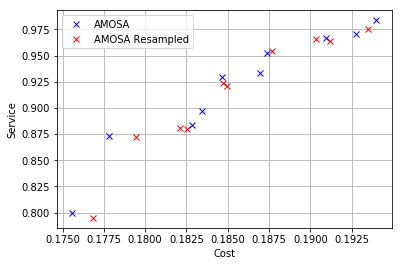

In [27]:
R_f1 = []
R_f2 = []

for i in range(len(Resamps)):

    R_f1.append(Resamps[i][0])
    R_f2.append(-Resamps[i][1])
    
X = []
Y = []

for i in range(len(a[1])):
    
    X.append(a[1][i][0])
    Y.append(-a[1][i][1])
 
plt.plot(X,Y,'bx',label = 'AMOSA')
plt.plot(R_f1,R_f2,'rx',label = 'AMOSA Resampled')
plt.legend()
plt.xlabel('Cost')
plt.ylabel('Service')
plt.grid(True)
plt.show()  